In [11]:
!datetime

/bin/bash: datetime: command not found


In [12]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [13]:
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
cudnn.benchmark = True
plt.ion()   # interactive m
from datetime import datetime
now = datetime.now
T0 = now()

from IPython import display
import sys
import seaborn as sns
import pandas as pd

In [14]:
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
#from torchvision.models import resnet50, ResNet50_Weights

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [16]:
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

In [17]:
class HAA_dataset(Dataset):
    "Video frame Dataset"
    def __init__(self,data_dir,usage='train'):
        self.data_dir = data_dir
        self.categories = os.listdir(self.data_dir)
        self.categories.sort()
        self.n_cat = len(self.categories)
        self.usage = usage
        
        ## To make test and val, deterministic
        ## Works on images
        ## doest seem to affect transforms
        if self.usage=='train':
            seed = np.random.randint(2147483647) 
            random.seed(seed) 
            torch.manual_seed(seed)
            np.random.seed(seed)
        else:
            seed = 42
            random.seed(seed) 
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        frames = []
        for category in self.categories:
            folder_frames = [frame for frame in os.listdir(os.path.join(data_dir,category)) if not frame.startswith('.')]
            folder_frames.sort()
            frames.append(folder_frames)
        self.frames = frames
        
        self.Ts = transforms.Compose([transforms.ColorJitter(brightness=.3, contrast=.3, saturation=.3, hue=.3),
        transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1, 2.0))])
        
    def __len__(self):
        return 10_000 # 
        
    def __getitem__(self, idx):
        
        self.rand_cat = np.random.randint(low=0,high=self.n_cat)
        self.rand_frame = np.random.randint(low=0,high=len(self.frames[self.rand_cat]))
        fn = os.path.join(self.data_dir,self.categories[self.rand_cat],self.frames[self.rand_cat][self.rand_frame])
        im = Image.open(fn)
        im = Ts(im)
        im = np.array(im)
        im = im/255
        im = im.swapaxes(2,1).swapaxes(0,1)
        
        #sample = {'image': torch.from_numpy(image).float(), 'label': torch.from_numpy(label).float()}  # make a dict with the image and the correct label
        sample = {'image': torch.from_numpy(im).float(), 'label': torch.from_numpy(np.array([self.rand_cat])).float()}  # make a dict with the image and the correct label
        return sample
    
    
    def get_im(self,rand_cat,frame_idx=None):
        self.rand_cat = rand_cat
        
        if type(frame_idx)==type(None): # For training, randomly choose image
            self.rand_frame = np.random.randint(low=0,high=len(self.frames[self.rand_cat]))
        else: # For val and test, deterministic 
            self.rand_frame = np.mod(frame_idx,len(self.frames[self.rand_cat])) # a spell that loops over array infinitely
            
        fn = os.path.join(self.data_dir,self.categories[self.rand_cat],self.frames[self.rand_cat][self.rand_frame])
        im = Image.open(fn)
        
        if self.usage=='train': # if training, add transforms for data augmentation
            im = self.Ts(im)
            
        im = np.array(im)
        im = im/255
        im = im.swapaxes(2,1).swapaxes(0,1)
        
        return im
    
    def get_batch(self,batch_size):
        self.this_batch_cats = np.random.randint(low=0,high=self.n_cat,size=batch_size)
        self.this_batch_cats = np.array(self.this_batch_cats)
        self.this_batch_im = [self.get_im(i) for i in self.this_batch_cats]
        self.this_batch_im = np.array(self.this_batch_im)
        sample = {'image': torch.from_numpy(self.this_batch_im).float(), 'label': torch.from_numpy(self.this_batch_cats).float()}  # make a dict with the image and the correct label
        return sample

In [18]:
orig_test_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_orig/test',usage='test')
bg_test_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_bg/test',usage='test')
seg_test_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_seg/test',usage='test')

#orig_test_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_orig/train',usage='train')
#bg_test_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_bg/train',usage='train')
#seg_test_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_seg/train',usage='train')

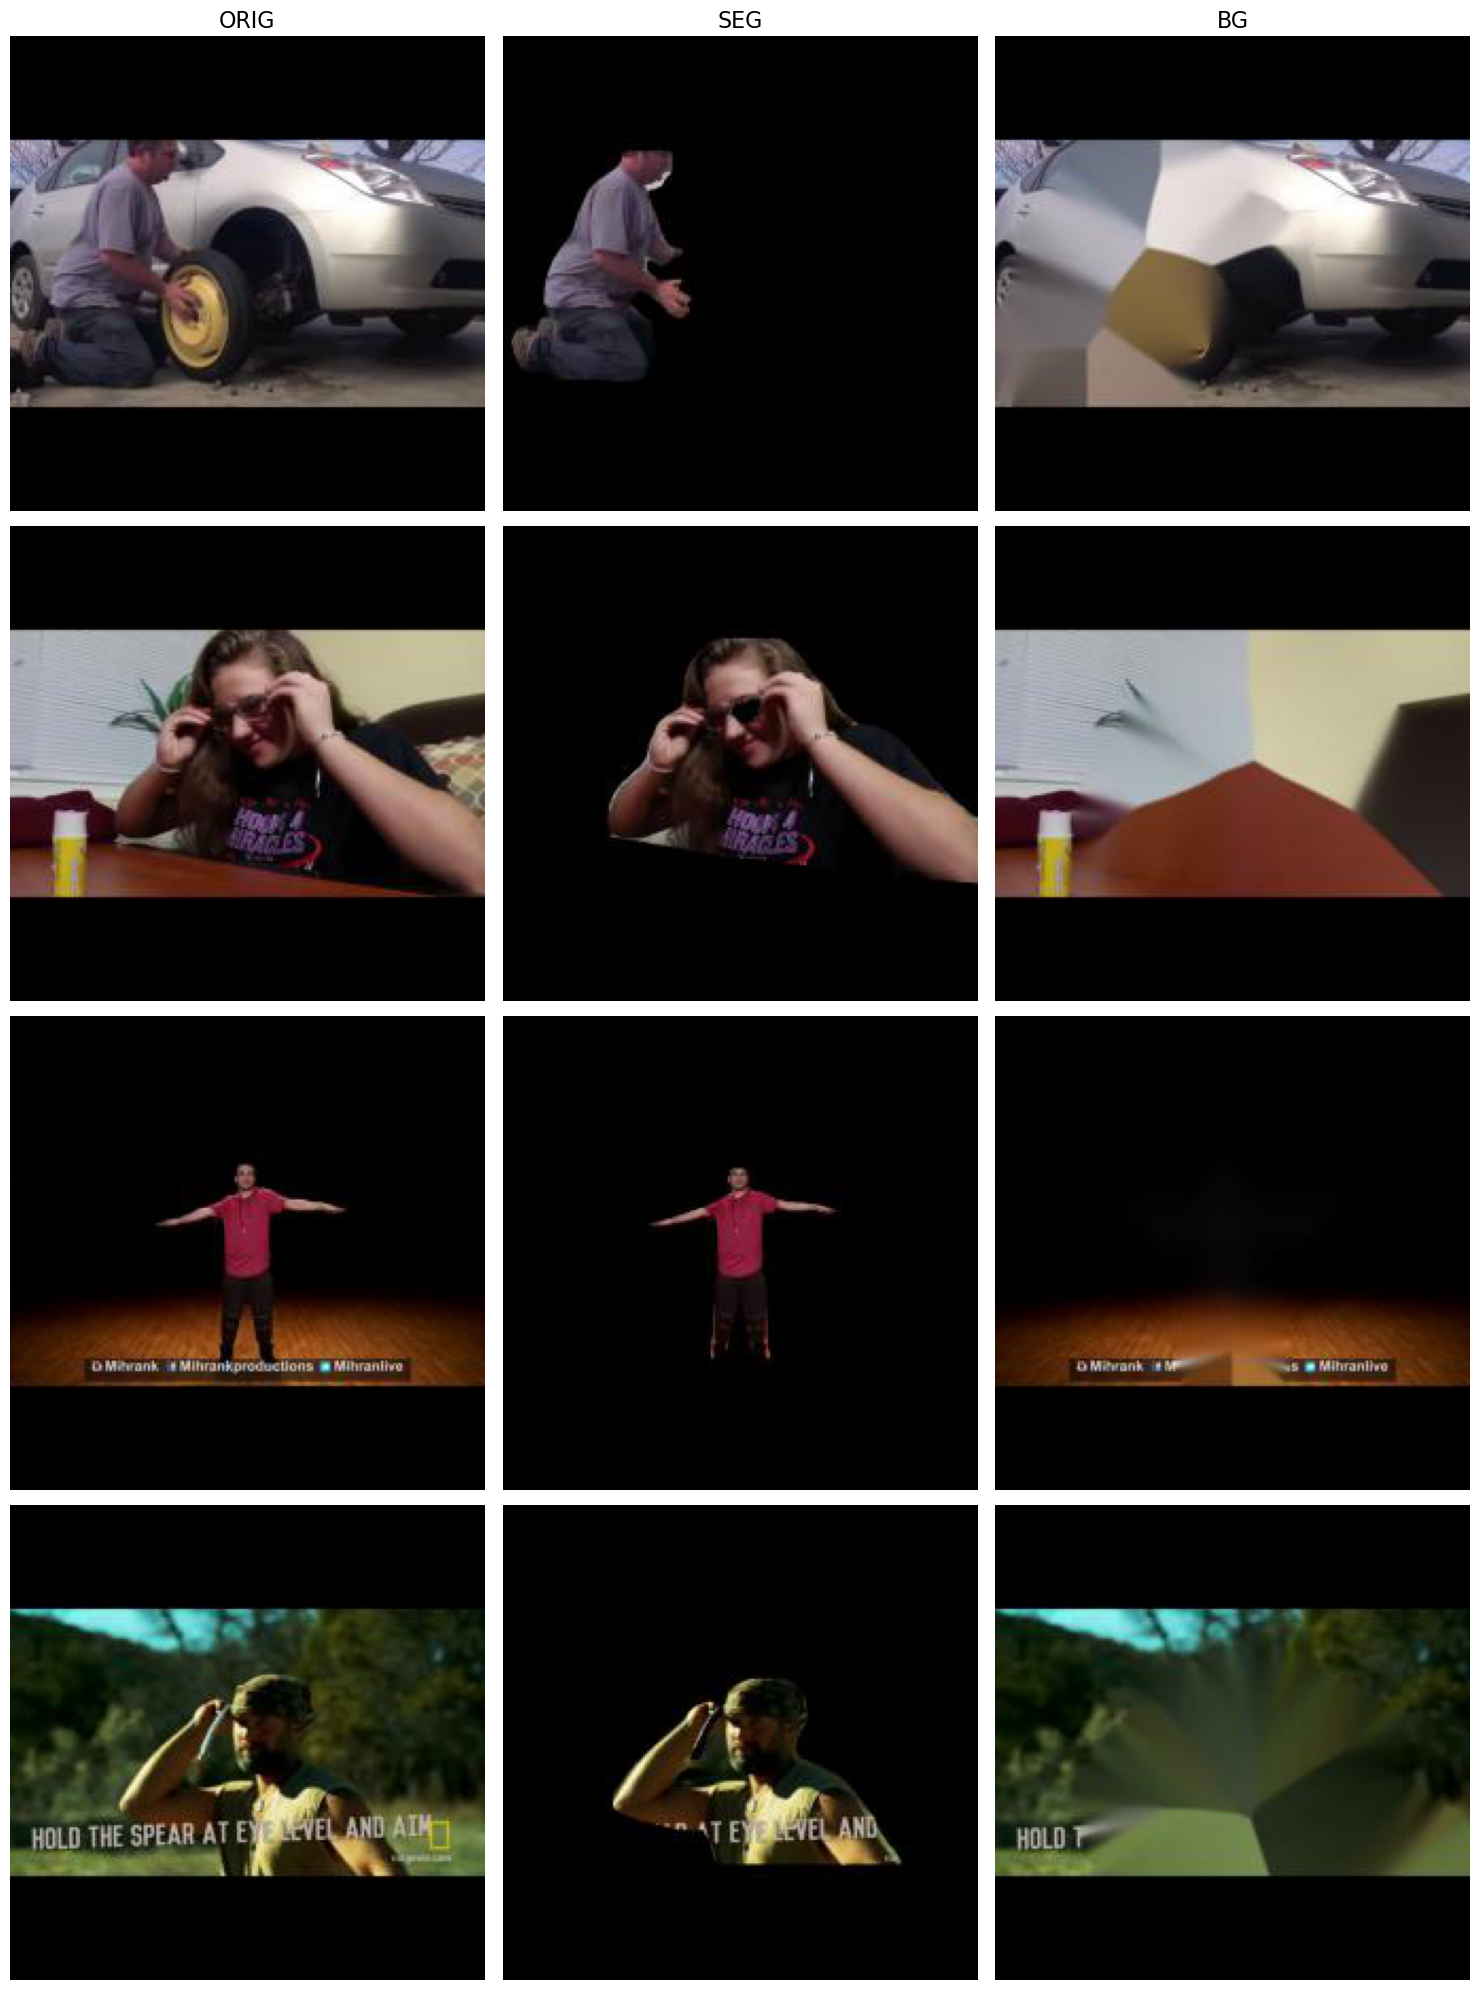

In [19]:
plt.figure(figsize=(15,20))
nc = 4
c = 0
for j in range(nc):
    c+=1;plt.subplot(nc,3,c)
    plt.imshow(orig_test_dataset.get_im(j,0).swapaxes(0,1).swapaxes(1,2))
    plt.axis('off');
    #plt.title('ORIG') if c==1 else pass
    if c==1 : plt.title('ORIG',fontsize=16)

    c+=1;plt.subplot(nc,3,c)
    plt.imshow(seg_test_dataset.get_im(j,0).swapaxes(0,1).swapaxes(1,2))
    plt.axis('off');
    if c==2 : plt.title('SEG',fontsize=16)

    c+=1;plt.subplot(nc,3,c)
    plt.imshow(bg_test_dataset.get_im(j,0).swapaxes(0,1).swapaxes(1,2))
    plt.axis('off');
    if c==3 : plt.title('BG',fontsize=16)

plt.tight_layout()

In [20]:
categories = np.array(orig_test_dataset.categories)

In [21]:
save_dir = './Data/pytorch-data/weights/xl_121_15_run_2'

In [22]:
net = resnet50()
net.fc = nn.Linear(net.fc.in_features,orig_test_dataset.n_cat)

net = net.to(device)
net.half();

In [23]:
net.load_state_dict(torch.load(os.path.join(save_dir,'weights')));
net.eval()

loss_memory = np.load(os.path.join(save_dir,'loss_memory.npy'))
val_memory = np.load(os.path.join(save_dir,'val_memory.npy'))
val_acc = np.load(os.path.join(save_dir,'val_acc.npy'))
val_acc5 = np.load(os.path.join(save_dir,'val_acc5.npy'))
train_acc = np.load(os.path.join(save_dir,'train_acc.npy'))

In [24]:
mturk_categories = np.load('mturk_categories.npy')

In [25]:
df = pd.read_csv('./Data/01_gifs_for_mTurk_orig/data_legend_fixed.csv')
df['action_orig'] = mturk_categories
df

,Unnamed: 0.1,Unnamed: 0,action,file,code,choice_1,choice_2,choice_3,choice_4,choice_5,action_orig
0,0,0,skateboard forward,gif_000.gif,460,softball pitch,play tambourine,play serpent,skateboard forward,screw car tire,skateboard_forward
1,1,1,golf part,gif_001.gif,148,whistle two hands,play maracas,golf part,floss dance,wear face mask,golf_part
2,2,2,pull ups,gif_002.gif,154,pull ups,volleyball set,cutting onion,wear face mask,handsaw,pull_ups
3,3,3,tight-rope walking,gif_003.gif,307,play recorder,tight-rope walking,whistle two hands,play maracas,arm wave,tight-rope_walking
4,4,4,using lawn mower,gif_004.gif,217,play leaf-flute,handsaw,yoga pigeon,play gong,using lawn mower,using_lawn_mower
...,...,...,...,...,...,...,...,...,...,...,...
75,75,75,adjusting glasses,gif_075.gif,348,screw car tire,volleyball set,adjusting glasses,rock balancing,pottery wheel,adjusting_glasses
76,76,76,eat apple,gif_076.gif,578,firemaking with bow,eat apple,draw handgun,play melodic,using typewriter,eat_apple
77,77,77,play erhu,gif_077.gif,265,add new car tire,watering plants,play cornett,play erhu,volleyball set,play_erhu
78,78,78,play triangle,gif_078.gif,48,jack up car,chalkboard,play triangle,running in place,firemaking with bow,play_triangle


In [26]:
def get_softmax(c,f):
    im = torch.tensor(val_dataset.get_im(c,f)[np.newaxis,:,:,:]).half().cuda()
    pred = net(im)
    pred = nn.functional.softmax(pred,dim=1)
    pred = pred.detach().cpu().numpy()[0]
    return pred

def get_avg_softmax(c):
    arr = np.array([get_softmax(c,f) for f in range(len(val_dataset.frames[c]))])
    return arr.mean(axis=0)

def get_avg_softmax_diff(c):
    arr = get_avg_softmax(c)
    return arr[c]-arr.max()

In [27]:
val_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_orig/val',usage='val')
diffs = np.array([get_avg_softmax_diff(c) for c in tqdm(range(val_dataset.n_cat))])
I = np.argsort(diffs)[-1::-1]
choose_categories = np.array(val_dataset.categories)[I][0:80]

100%|███████████████████████████████████████████| 121/121 [01:24<00:00,  1.43it/s]


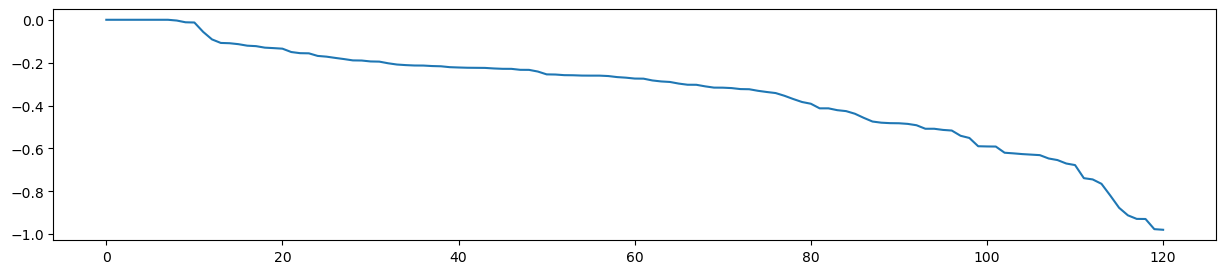

In [28]:
plt.figure(figsize=(15,3))
plt.plot(diffs[I])

In [29]:
np.array([choose_category in df['action_orig'].values for choose_category in choose_categories]).mean()

1.0

In [34]:
#orig_val_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_orig/val',usage='test')
#which_dataset = HAA_dataset('./Data/pytorch-data/xl_280_10_action_data_orig/test',usage='test')
which_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_seg/test',usage='test')

In [35]:
## GATHER ALL VALUES
#which_dataset = orig_val_dataset
cat_vals = []
for c in tqdm(range(len(which_dataset.categories))):
    frame_vals = []
    for f in range(len(which_dataset.frames[c])):
        im = torch.tensor(which_dataset.get_im(c,f)[np.newaxis,:,:,:]).half().cuda()
        pred = net(im)
        pred = pred.detach().cpu().numpy()[0]
        frame_vals.append( pred )
    cat_vals.append(frame_vals)

100%|███████████████████████████████████████████| 121/121 [02:26<00:00,  1.21s/it]


In [32]:
data = {'categories' : which_dataset.categories,'values' : cat_vals}

In [36]:
import pickle 
with open('./Data/softmax_vals_seg_121_test.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [ ]:
#orig_val_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_orig/val',usage='test')
which_dataset = HAA_dataset('./Data/pytorch-data/xl_280_10_action_data_orig/val',usage='test')

## GATHER ALL VALUES
#which_dataset = orig_val_dataset
cat_vals = []
for c in tqdm(range(len(which_dataset.categories))):
    frame_vals = []
    for f in range(len(which_dataset.frames[c])):
        im = torch.tensor(which_dataset.get_im(c,f)[np.newaxis,:,:,:]).half().cuda()
        pred = net(im)
        pred = pred.detach().cpu().numpy()[0]
        frame_vals.append( pred )
    cat_vals.append(frame_vals)
    
data = {'categories' : which_dataset.categories,'values' : cat_vals}

with open('./Data/softmax_vals_orig_280_val.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

 50%|████████████████████▋                    | 141/280 [02:42<06:44,  2.91s/it]

In [ ]:
pwd

In [20]:
def get_choose_121_acc(which_dataset):
    acc_vec = np.zeros(121)
    for c in tqdm(range(121)):
        #which_category = df['action_orig'].values[c]
        which_category = categories[c]
        idx_true = np.argwhere(which_category==categories)[0][0]
        #answer_choices = [df.loc[df['action']==df[key].values[c]]['action_orig'].values[0] for key in ['choice_1','choice_2','choice_3','choice_4','choice_5']]
        #answer_choices = df['action_orig'].values
        
        answer_choices = random.sample(list(categories[categories!=which_category]),120)
        answer_choices.append(which_category)
        
        idx_answer_choices = [np.argwhere(answer_choice==categories)[0][0] for answer_choice in answer_choices]
        for f in range(len(which_dataset.frames[c])):
        #for f in range(250):
            im = torch.tensor(which_dataset.get_im(c,f)[np.newaxis,:,:,:]).half().cuda()
            pred = net(im)
            pred = pred.detach().cpu().numpy()[0]
            is_correct = pred[idx_answer_choices].argmax()==(idx_answer_choices==idx_true).argmax()
            acc_vec[c] = acc_vec[c]+is_correct
        acc_vec[c] = acc_vec[c]/f
        
    return acc_vec

100%|██████████| 121/121 [02:10<00:00,  1.08s/it]


Text(0, 0.5, 'accuracy')

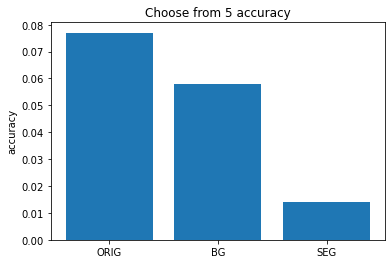

In [21]:
acc_orig = get_choose_121_acc(orig_test_dataset)
acc_bg = get_choose_121_acc(bg_test_dataset)
acc_seg = get_choose_121_acc(seg_test_dataset)

ys = [acc_orig.mean(),acc_bg.mean(),acc_seg.mean()]
ys = np.array(ys)
ys = ys
xs = np.arange(len(ys))

plt.bar(xs,ys)
plt.xticks(ticks=xs,labels=['ORIG','BG','SEG']);
plt.title('Choose from 5 accuracy')
plt.ylabel('accuracy')

In [ ]:
which_dataset = orig_test_dataset
#for c in tqdm(range(len(acc_vec)))
#for f in range(len(which_dataset.frames[c])):

In [22]:
def get_choose_5_acc(which_dataset):
    acc_vec = np.zeros(80)
    for c in tqdm(range(len(acc_vec))):
        which_category = df['action_orig'].values[c]
        #which_category = choose_categories[c]
        #which_category = categories[c]
        idx_true = np.argwhere(which_category==categories)[0][0]
        answer_choices = [df.loc[df['action']==df[key].values[c]]['action_orig'].values[0] for key in ['choice_1','choice_2','choice_3','choice_4','choice_5']]
        #answer_choices = df['action_orig'].values
        
        #answer_choices = random.sample(list(categories[categories!=which_category]),4)
        #answer_choices.append(which_category)
        
        idx_answer_choices = [np.argwhere(answer_choice==categories)[0][0] for answer_choice in answer_choices]
        
        #idx_answer_choices = get_avg_softmax(idx_true).argsort()[-5::]
        #idx_answer_choices = get_avg_softmax(idx_true).argsort()[0:5]
#         if idx_true not in idx_answer_choices:
#             idx_answer_choices[0] = idx_true
                
        for f in range(len(which_dataset.frames[c])):
        #for f in range(250):
            im = torch.tensor(which_dataset.get_im(c,f)[np.newaxis,:,:,:]).half().cuda()
            pred = net(im)
            pred = pred.detach().cpu().numpy()[0]
            is_correct = pred[idx_answer_choices].argmax()==(idx_answer_choices==idx_true).argmax()
            acc_vec[c] = acc_vec[c]+is_correct
        acc_vec[c] = acc_vec[c]/f
        
    return acc_vec

100%|██████████| 80/80 [01:13<00:00,  1.09it/s]


Text(0, 0.5, 'accuracy')

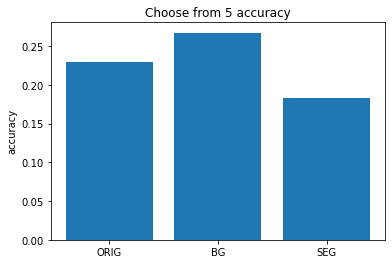

In [23]:
acc_orig = get_choose_5_acc(orig_test_dataset)
acc_bg = get_choose_5_acc(bg_test_dataset)
acc_seg = get_choose_5_acc(seg_test_dataset)

ys = [acc_orig.mean(),acc_bg.mean(),acc_seg.mean()]
ys = np.array(ys)
ys = ys
xs = np.arange(len(ys))

plt.bar(xs,ys)
plt.xticks(ticks=xs,labels=['ORIG','BG','SEG']);
plt.title('Choose from 5 accuracy')
plt.ylabel('accuracy')

In [24]:
def get_choose_5_acc(which_dataset):
    acc_vec = np.zeros(80)
    for c in tqdm(range(len(acc_vec))):
        which_category = df['action_orig'].values[c]
        #which_category = choose_categories[c]
        #which_category = categories[c]
        idx_true = np.argwhere(which_category==categories)[0][0]
        #answer_choices = [df.loc[df['action']==df[key].values[c]]['action_orig'].values[0] for key in ['choice_1','choice_2','choice_3','choice_4','choice_5']]
        #answer_choices = df['action_orig'].values
        
        answer_choices = answer_choices_pool[c,:]
        #answer_choices = random.sample(list(categories[categories!=which_category]),4)
        #answer_choices.append(which_category)
        
        idx_answer_choices = [np.argwhere(answer_choice==categories)[0][0] for answer_choice in answer_choices]
        idx_answer_choices.append( idx_true )
        
        #idx_answer_choices = get_avg_softmax(idx_true).argsort()[-5::]
        #idx_answer_choices = get_avg_softmax(idx_true).argsort()[0:5]
#         if idx_true not in idx_answer_choices:
#             idx_answer_choices[0] = idx_true
                
        for f in range(len(which_dataset.frames[c])):
        #for f in range(250):
            im = torch.tensor(which_dataset.get_im(c,f)[np.newaxis,:,:,:]).half().cuda()
            pred = net(im)
            pred = pred.detach().cpu().numpy()[0]
            is_correct = pred[idx_answer_choices].argmax()==(idx_answer_choices==idx_true).argmax()
            acc_vec[c] = acc_vec[c]+is_correct
        acc_vec[c] = acc_vec[c]/f
        
    return acc_vec

100%|██████████| 80/80 [01:21<00:00,  1.02s/it]


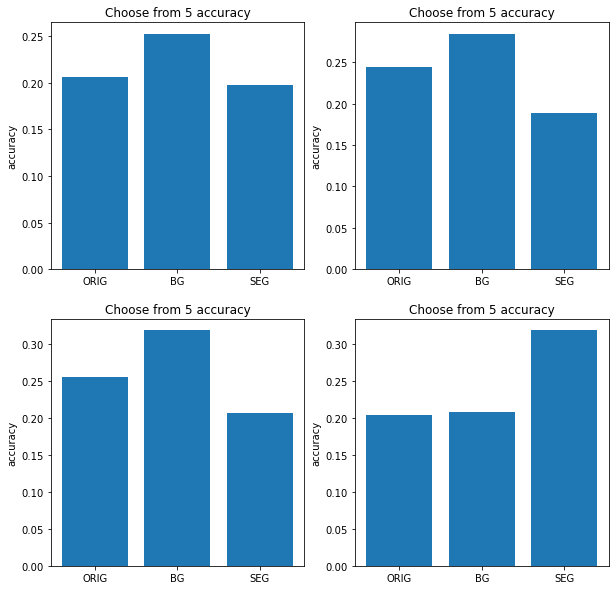

In [25]:
plt.figure(figsize=(10,10))

for sp in range(4):
    answer_choices_pool = []
    for c in range(80):
        answer_choices_pool.append( random.sample(list(df['action_orig'].values[np.arange(80)!=c]),4) )
    answer_choices_pool = np.array(answer_choices_pool)

    acc_orig = get_choose_5_acc(orig_test_dataset)
    acc_bg = get_choose_5_acc(bg_test_dataset)
    acc_seg = get_choose_5_acc(seg_test_dataset)
    
    plt.subplot(2,2,sp+1)
    ys = [acc_orig.mean(),acc_bg.mean(),acc_seg.mean()]
    ys = np.array(ys)
    ys = ys
    xs = np.arange(len(ys))

    plt.bar(xs,ys)
    plt.xticks(ticks=xs,labels=['ORIG','BG','SEG']);
    plt.title('Choose from 5 accuracy')
    plt.ylabel('accuracy')

In [26]:
def get_choose_5_acc(which_dataset):
    acc_vec = np.zeros(80)
    for c in tqdm(range(len(acc_vec))):
        which_category = df['action_orig'].values[c]
        #which_category = choose_categories[c]
        #which_category = categories[c]
        idx_true = np.argwhere(which_category==categories)[0][0]
        #answer_choices = [df.loc[df['action']==df[key].values[c]]['action_orig'].values[0] for key in ['choice_1','choice_2','choice_3','choice_4','choice_5']]
        #answer_choices = df['action_orig'].values
        
        #answer_choices = random.sample(list(categories[categories!=which_category]),4)
        #answer_choices.append(which_category)
        
        #idx_answer_choices = [np.argwhere(answer_choice==categories)[0][0] for answer_choice in answer_choices]
        
        idx_answer_choices = get_avg_softmax(idx_true).argsort()[-5::]
        #idx_answer_choices = get_avg_softmax(idx_true).argsort()[0:5]
        if idx_true not in idx_answer_choices:
            idx_answer_choices[0] = idx_true
                
        for f in range(len(which_dataset.frames[c])):
        #for f in range(250):
            im = torch.tensor(which_dataset.get_im(c,f)[np.newaxis,:,:,:]).half().cuda()
            pred = net(im)
            pred = pred.detach().cpu().numpy()[0]
            is_correct = pred[idx_answer_choices].argmax()==(idx_answer_choices==idx_true).argmax()
            acc_vec[c] = acc_vec[c]+is_correct
        acc_vec[c] = acc_vec[c]/f
        
    return acc_vec

100%|██████████| 80/80 [01:40<00:00,  1.26s/it]


Text(0, 0.5, 'accuracy')

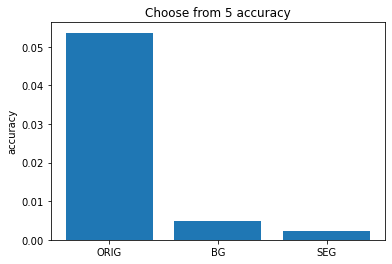

In [27]:
acc_orig = get_choose_5_acc(orig_test_dataset)
acc_bg = get_choose_5_acc(bg_test_dataset)
acc_seg = get_choose_5_acc(seg_test_dataset)

ys = [acc_orig.mean(),acc_bg.mean(),acc_seg.mean()]
ys = np.array(ys)
ys = ys-.2
xs = np.arange(len(ys))

plt.bar(xs,ys)
plt.xticks(ticks=xs,labels=['ORIG','BG','SEG']);
plt.title('Choose from 5 accuracy')
plt.ylabel('accuracy')

In [28]:
def get_choose_5_acc(which_dataset):
    acc_vec = np.zeros(80)
    for c in tqdm(range(len(acc_vec))):
        which_category = df['action_orig'].values[c]
        #which_category = choose_categories[c]
        #which_category = categories[c]
        idx_true = np.argwhere(which_category==categories)[0][0]
        #answer_choices = [df.loc[df['action']==df[key].values[c]]['action_orig'].values[0] for key in ['choice_1','choice_2','choice_3','choice_4','choice_5']]
        #answer_choices = df['action_orig'].values
        
        #answer_choices = random.sample(list(categories[categories!=which_category]),4)
        #answer_choices.append(which_category)
        
        #idx_answer_choices = [np.argwhere(answer_choice==categories)[0][0] for answer_choice in answer_choices]
        
        #idx_answer_choices = get_avg_softmax(idx_true).argsort()[-5::]
        idx_answer_choices = get_avg_softmax(idx_true).argsort()[0:5]
        if idx_true not in idx_answer_choices:
            idx_answer_choices[0] = idx_true
                
        for f in range(len(which_dataset.frames[c])):
        #for f in range(250):
            im = torch.tensor(which_dataset.get_im(c,f)[np.newaxis,:,:,:]).half().cuda()
            pred = net(im)
            pred = pred.detach().cpu().numpy()[0]
            is_correct = pred[idx_answer_choices].argmax()==(idx_answer_choices==idx_true).argmax()
            acc_vec[c] = acc_vec[c]+is_correct
        acc_vec[c] = acc_vec[c]/f
        
    return acc_vec

100%|██████████| 80/80 [01:58<00:00,  1.49s/it]


Text(0, 0.5, 'accuracy')

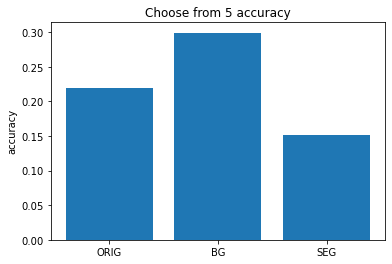

In [29]:
acc_orig = get_choose_5_acc(orig_test_dataset)
acc_bg = get_choose_5_acc(bg_test_dataset)
acc_seg = get_choose_5_acc(seg_test_dataset)

ys = [acc_orig.mean(),acc_bg.mean(),acc_seg.mean()]
ys = np.array(ys)
ys = ys-.2
xs = np.arange(len(ys))

plt.bar(xs,ys)
plt.xticks(ticks=xs,labels=['ORIG','BG','SEG']);
plt.title('Choose from 5 accuracy')
plt.ylabel('accuracy')

In [40]:
def get_choose_5_acc(which_dataset):
    acc_vec = np.zeros(80)
    for c in tqdm(range(len(acc_vec))):
        which_category = df['action_orig'].values[c]
        #which_category = choose_categories[c]
        #which_category = categories[c]
        idx_true = np.argwhere(which_category==categories)[0][0]
        #answer_choices = [df.loc[df['action']==df[key].values[c]]['action_orig'].values[0] for key in ['choice_1','choice_2','choice_3','choice_4','choice_5']]
        #answer_choices = df['action_orig'].values
        
        #answer_choices = random.sample(list(categories[categories!=which_category]),4)
        #answer_choices.append(which_category)
        
        #idx_answer_choices = [np.argwhere(answer_choice==categories)[0][0] for answer_choice in answer_choices]
        
        #idx_answer_choices = get_avg_softmax(idx_true).argsort()[-5::]
        
        #idx_answer_choices = get_avg_softmax(idx_true).argsort()[0:5]
        idx_answer_choices = get_avg_softmax(idx_true).argsort()[np.linspace(0,80,5).astype(int)]
        if idx_true not in idx_answer_choices:
            idx_answer_choices[0] = idx_true
                
        for f in range(len(which_dataset.frames[c])):
        #for f in range(250):
            im = torch.tensor(which_dataset.get_im(c,f)[np.newaxis,:,:,:]).half().cuda()
            pred = net(im)
            pred = pred.detach().cpu().numpy()[0]
            is_correct = pred[idx_answer_choices].argmax()==(idx_answer_choices==idx_true).argmax()
            acc_vec[c] = acc_vec[c]+is_correct
        acc_vec[c] = acc_vec[c]/f
        
    return acc_vec

In [53]:
#get_avg_softmax(0)

100%|██████████| 80/80 [02:03<00:00,  1.55s/it]


Text(0, 0.5, 'accuracy')

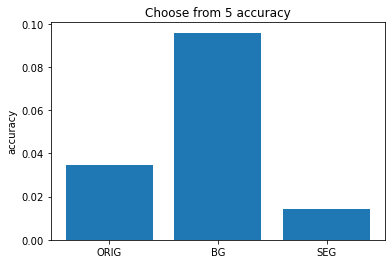

In [41]:
acc_orig = get_choose_5_acc(orig_test_dataset)
acc_bg = get_choose_5_acc(bg_test_dataset)
acc_seg = get_choose_5_acc(seg_test_dataset)

ys = [acc_orig.mean(),acc_bg.mean(),acc_seg.mean()]
ys = np.array(ys)
ys = ys-.2
xs = np.arange(len(ys))

plt.bar(xs,ys)
plt.xticks(ticks=xs,labels=['ORIG','BG','SEG']);
plt.title('Choose from 5 accuracy')
plt.ylabel('accuracy')

In [54]:
def get_choose_5_acc(which_dataset):
    acc_vec = np.zeros(80)
    for c in tqdm(range(len(acc_vec))):
        which_category = df['action_orig'].values[c]
        #which_category = choose_categories[c]
        #which_category = categories[c]
        idx_true = np.argwhere(which_category==categories)[0][0]
        #answer_choices = [df.loc[df['action']==df[key].values[c]]['action_orig'].values[0] for key in ['choice_1','choice_2','choice_3','choice_4','choice_5']]
        #answer_choices = df['action_orig'].values
        
        #answer_choices = random.sample(list(categories[categories!=which_category]),4)
        #answer_choices.append(which_category)
        
        #idx_answer_choices = [np.argwhere(answer_choice==categories)[0][0] for answer_choice in answer_choices]
        
        #idx_answer_choices = get_avg_softmax(idx_true).argsort()[-5::]
        
        #idx_answer_choices = get_avg_softmax(idx_true).argsort()[0:5]
        idx_answer_choices = get_avg_softmax(idx_true).argsort()[np.linspace(0,80,20).astype(int)]
        if idx_true not in idx_answer_choices:
            idx_answer_choices[0] = idx_true
                
        for f in range(len(which_dataset.frames[c])):
        #for f in range(250):
            im = torch.tensor(which_dataset.get_im(c,f)[np.newaxis,:,:,:]).half().cuda()
            pred = net(im)
            pred = pred.detach().cpu().numpy()[0]
            is_correct = pred[idx_answer_choices].argmax()==(idx_answer_choices==idx_true).argmax()
            acc_vec[c] = acc_vec[c]+is_correct
        acc_vec[c] = acc_vec[c]/f
        
    return acc_vec

100%|██████████| 80/80 [01:54<00:00,  1.43s/it]


Text(0, 0.5, 'accuracy')

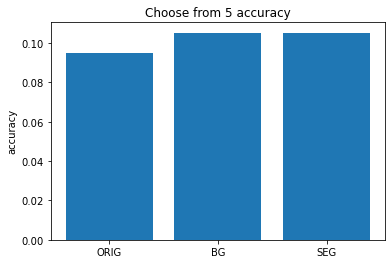

In [55]:
acc_orig = get_choose_5_acc(orig_test_dataset)
acc_bg = get_choose_5_acc(bg_test_dataset)
acc_seg = get_choose_5_acc(seg_test_dataset)

ys = [acc_orig.mean(),acc_bg.mean(),acc_seg.mean()]
ys = np.array(ys)
ys = ys
xs = np.arange(len(ys))

plt.bar(xs,ys)
plt.xticks(ticks=xs,labels=['ORIG','BG','SEG']);
plt.title('Choose from 5 accuracy')
plt.ylabel('accuracy')

In [19]:
val_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_orig/test',usage='test')
diffs = np.array([get_avg_softmax_diff(c) for c in tqdm(range(val_dataset.n_cat))])
I = np.argsort(diffs)[-1::-1]
choose_categories = np.array(val_dataset.categories)[I][0:80]

In [23]:
def get_choose_5_acc(which_dataset):
    acc_vec = np.zeros(80)
    
    #for c in tqdm(range(len(acc_vec))):
    for c in range(len(acc_vec)):
        #which_category = df['action_orig'].values[c]
        which_category = choose_categories[c]
        #which_category = categories[c]
        idx_true = np.argwhere(which_category==categories)[0][0]
        #answer_choices = [df.loc[df['action']==df[key].values[c]]['action_orig'].values[0] for key in ['choice_1','choice_2','choice_3','choice_4','choice_5']]
        #answer_choices = df['action_orig'].values
        
        #answer_choices = random.sample(list(categories[categories!=which_category]),4)
        #answer_choices.append(which_category)
        
        #idx_answer_choices = [np.argwhere(answer_choice==categories)[0][0] for answer_choice in answer_choices]
        
        idx_answer_choices = get_avg_softmax(idx_true).argsort()[-5::]
        #idx_answer_choices = get_avg_softmax(idx_true).argsort()[0:5]
        if idx_true not in idx_answer_choices:
            idx_answer_choices[0] = idx_true
                
        for f in range(len(which_dataset.frames[c])):
        #for f in range(250):
            im = torch.tensor(which_dataset.get_im(c,f)[np.newaxis,:,:,:]).half().cuda()
            pred = net(im)
            pred = pred.detach().cpu().numpy()[0]
            is_correct = pred[idx_answer_choices].argmax()==(idx_answer_choices==idx_true).argmax()
            acc_vec[c] = acc_vec[c]+is_correct
        acc_vec[c] = acc_vec[c]/f
        
    return acc_vec

1/3
2/3
3/3


Text(0, 0.5, 'accuracy')

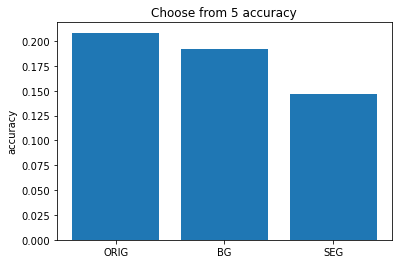

In [25]:
print('1/3');acc_orig = get_choose_5_acc(orig_test_dataset)
print('2/3');acc_bg = get_choose_5_acc(bg_test_dataset)
print('3/3');acc_seg = get_choose_5_acc(seg_test_dataset)

ys = [acc_orig.mean(),acc_bg.mean(),acc_seg.mean()]
ys = np.array(ys)
ys = ys
xs = np.arange(len(ys))

plt.bar(xs,ys)
plt.xticks(ticks=xs,labels=['ORIG','BG','SEG']);
plt.title('Choose from 5 accuracy')
plt.ylabel('accuracy')